In [61]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
!pip install contractions

In [63]:
!pip install -U nltk

In [64]:
pip install gensim

# Import necessary libary

In [65]:
import re
import string
import numpy as np
import pandas as pd
import contractions
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# NLTK Libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

# Scikit-Learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Joblib for Saving & Loading Models
import joblib


# Download necessary NLTK data
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load Data

In [66]:
df = pd.read_csv("/content/drive/MyDrive/Ironhack/data.csv")
df.head()

,label,title,text,subject,date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


# Exploratory Data Analysis (EDA)

In [67]:
# check for missing values
missing_values = df.isnull().sum()
missing_values

,0
label,0
title,0
text,0
subject,0
date,0


In [68]:
# info about the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39942 entries, 0 to 39941
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    39942 non-null  int64 
 1   title    39942 non-null  object
 2   text     39942 non-null  object
 3   subject  39942 non-null  object
 4   date     39942 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


In [69]:
# check label distribution
print(df['label'].value_counts())

label
1    19999
0    19943
Name: count, dtype: int64


In [70]:
df.describe(include='object')

,title,text,subject,date
count,39942,39942,39942,39942
unique,36083,35977,6,2392
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017"
freq,14,606,11272,182


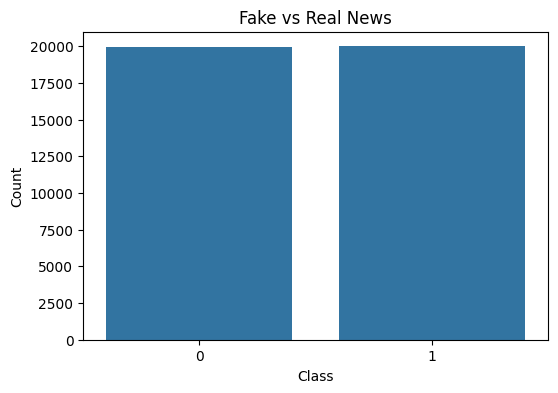

In [71]:
# Plot distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'])
plt.title("Fake vs Real News")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## First take and try on sample of data

In [72]:
sample_size = 15000
df_sample = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), sample_size // df['label'].nunique())))
print("\nSampled Data:")
print(df_sample['label'].value_counts())



Sampled Data:
label
0    7500
1    7500
Name: count, dtype: int64


<ipython-input-72-99764022ae85>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), sample_size // df['label'].nunique())))


In [73]:
df_sample

,label,title,text,subject,date
39505,0,FITTING END FOR COMMUNIST DICTATOR: Hilarious ...,As FoxNews.com reported:The Russian-made jeep ...,left-news,"Dec 4, 2016"
24646,0,"Stephen King Compares Trump To Cthulhu, An Of...",Donald Trump is so deplorable that even Cthulh...,News,"September 13, 2016"
24420,0,WATCH: Joe Biden Gives DEVASTATING Critique O...,"On Thursday night, Vice President Joe Biden jo...",News,"September 30, 2016"
27509,0,Billionaire Liberal Governor Boosted State’s ...,Many Republicans often argue raising the minim...,News,"March 13, 2016"
20138,0,GOP Lawmaker Links Abortion To The Economy In...,Republican lawmakers come up with the most rid...,News,"November 4, 2017"
...,...,...,...,...,...
13099,1,Turkey investigates reports that folk dancers ...,ANKARA (Reuters) - Turkey is investigating rep...,worldnews,"December 5, 2017"
15858,1,Turkey's defense industry says planning 22 pro...,ANKARA (Reuters) - Turkey is planning 22 new d...,worldnews,"November 2, 2017"
6422,1,Trump's choice for U.S. attorney general says ...,WASHINGTON (Reuters) - U.S. President-elect Do...,politicsNews,"January 10, 2017"
6813,1,White House says cyber review to go beyond 20...,WASHINGTON (Reuters) - The White House said on...,politicsNews,"December 9, 2016"


In [74]:
df_sample.drop(['subject','date'],axis=1,inplace=True)

In [75]:
df_sample

,label,title,text
39505,0,FITTING END FOR COMMUNIST DICTATOR: Hilarious ...,As FoxNews.com reported:The Russian-made jeep ...
24646,0,"Stephen King Compares Trump To Cthulhu, An Of...",Donald Trump is so deplorable that even Cthulh...
24420,0,WATCH: Joe Biden Gives DEVASTATING Critique O...,"On Thursday night, Vice President Joe Biden jo..."
27509,0,Billionaire Liberal Governor Boosted State’s ...,Many Republicans often argue raising the minim...
20138,0,GOP Lawmaker Links Abortion To The Economy In...,Republican lawmakers come up with the most rid...
...,...,...,...
13099,1,Turkey investigates reports that folk dancers ...,ANKARA (Reuters) - Turkey is investigating rep...
15858,1,Turkey's defense industry says planning 22 pro...,ANKARA (Reuters) - Turkey is planning 22 new d...
6422,1,Trump's choice for U.S. attorney general says ...,WASHINGTON (Reuters) - U.S. President-elect Do...
6813,1,White House says cyber review to go beyond 20...,WASHINGTON (Reuters) - The White House said on...


In [76]:
# Null values
df_sample.isnull().sum()

,0
label,0
title,0
text,0


# Data Preprocessing

*   Combines the title and text
*   Removes punctuation
*   Tokenizes the text
*   Removes stop words
*   Generates n-grams
*   Converts text to lowercase

In [77]:
# Function to generate n-grams
def generate_ngrams(tokens, n=3):
    return list(ngrams(tokens, n))

# Function to preprocess text
def text_preprocessing(text, ngram_range=(1, 3)):
    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Expand contractions
    expanded_text = contractions.fix(" ".join(lemmatized_tokens))

    # Tokenize again after contraction expansion (so it's consistent)
    tokens = word_tokenize(expanded_text)

    # Generate n-grams (using the max n from the range)
    ngram_tokens = generate_ngrams(tokens, n=ngram_range[1])

    # Convert to lowercase and join n-grams into a single string
    ngram_tokens = [' '.join(ngram).lower() for ngram in ngram_tokens]
    final_text = " ".join(ngram_tokens)

    return final_text

def preprocess_data(df):
    # Combine title and text
    df['combined_text'] = df['title'].fillna('') + " " + df['text'].fillna('')

    # Apply preprocessing to the combined column
    df['processed_text'] = df['combined_text'].apply(lambda x: text_preprocessing(x, ngram_range=(1, 3)))

    return df



In [78]:
df_sample = preprocess_data(df_sample)

In [79]:
df_sample

,label,title,text,combined_text,processed_text
39505,0,FITTING END FOR COMMUNIST DICTATOR: Hilarious ...,As FoxNews.com reported:The Russian-made jeep ...,FITTING END FOR COMMUNIST DICTATOR: Hilarious ...,fitting end communist end communist dictator c...
24646,0,"Stephen King Compares Trump To Cthulhu, An Of...",Donald Trump is so deplorable that even Cthulh...,"Stephen King Compares Trump To Cthulhu, An Of...",stephen king compares king compares trump comp...
24420,0,WATCH: Joe Biden Gives DEVASTATING Critique O...,"On Thursday night, Vice President Joe Biden jo...",WATCH: Joe Biden Gives DEVASTATING Critique O...,watch joe biden joe biden gives biden gives de...
27509,0,Billionaire Liberal Governor Boosted State’s ...,Many Republicans often argue raising the minim...,Billionaire Liberal Governor Boosted State’s ...,billionaire liberal governor liberal governor ...
20138,0,GOP Lawmaker Links Abortion To The Economy In...,Republican lawmakers come up with the most rid...,GOP Lawmaker Links Abortion To The Economy In...,gop lawmaker links lawmaker links abortion lin...
...,...,...,...,...,...
13099,1,Turkey investigates reports that folk dancers ...,ANKARA (Reuters) - Turkey is investigating rep...,Turkey investigates reports that folk dancers ...,turkey investigates report investigates report...
15858,1,Turkey's defense industry says planning 22 pro...,ANKARA (Reuters) - Turkey is planning 22 new d...,Turkey's defense industry says planning 22 pro...,turkeys defense industry defense industry say ...
6422,1,Trump's choice for U.S. attorney general says ...,WASHINGTON (Reuters) - U.S. President-elect Do...,Trump's choice for U.S. attorney general says ...,trumps choice us choice us attorney us attorne...
6813,1,White House says cyber review to go beyond 20...,WASHINGTON (Reuters) - The White House said on...,White House says cyber review to go beyond 20...,white house say house say cyber say cyber revi...


# Build a classical NLP model

In [80]:
vectorizer = TfidfVectorizer(min_df=10)
X = vectorizer.fit_transform(df_sample['processed_text'])  # Fit & transform on processed text

y = df_sample['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [81]:
# Train the model
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [82]:
y_train_pred_nb = model.predict(X_train)
y_test_pred_nb = model.predict(X_test)

# Evaluate accuracy
train_acc_nb = accuracy_score(y_train, y_train_pred_nb)
test_acc_nb = accuracy_score(y_test, y_test_pred_nb)

# Print results
print(f"Multinomial Training Accuracy: {train_acc_nb:.4f}")
print(f"Multinomial Test Accuracy: {test_acc_nb:.4f}")
print(f"Classification Report for Multinomial:")
print(classification_report(y_test, y_test_pred_nb))

Multinomial Training Accuracy: 0.9492
Multinomial Test Accuracy: 0.9400
Classification Report for Multinomial:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1507
           1       0.94      0.94      0.94      1493

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



# Train in the whole dataset

In [83]:
df = preprocess_data(df)
df

,label,title,text,subject,date,combined_text,processed_text
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t...",us budget fight budget fight loom fight loom r...
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...,us military accept military accept transgender...
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...,senior us republican us republican senator rep...
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...,fbi russia probe russia probe helped probe hel...
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...,trump want postal want postal service postal s...
...,...,...,...,...,...,...,...
39937,0,THIS IS NOT A JOKE! Soros-Linked Group Has Pla...,"The Left has been organizing for decades, and ...",left-news,"Sep 22, 2016",THIS IS NOT A JOKE! Soros-Linked Group Has Pla...,joke soroslinked group soroslinked group plan ...
39938,0,THE SMARTEST WOMAN In Politics: “How Trump Can...,Monica Crowley offers some of the most brillia...,left-news,"Sep 22, 2016",THE SMARTEST WOMAN In Politics: “How Trump Can...,smartest woman politics woman politics trump p...
39939,0,BREAKING! SHOCKING VIDEO FROM CHARLOTTE RIOTS:...,Protest underway in Charlotte: Things got com...,left-news,"Sep 21, 2016",BREAKING! SHOCKING VIDEO FROM CHARLOTTE RIOTS:...,breaking shocking video shocking video charlot...
39940,0,BREAKING! Charlotte News Station Reports Cops ...,"Local Charlotte, NC news station WSOCTV is rep...",left-news,"Sep 21, 2016",BREAKING! Charlotte News Station Reports Cops ...,breaking charlotte news charlotte news station...


In [84]:
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['label'], test_size=0.2, random_state=42)

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(min_df=10)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Save vectorizer
joblib.dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']

# (1) Multinomial Naïve Bayes



🔹 Multinomial Naïve Bayes Results:
Training Accuracy: 0.9475
Test Accuracy: 0.9452

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      3996
           1       0.95      0.94      0.95      3993

    accuracy                           0.95      7989
   macro avg       0.95      0.95      0.95      7989
weighted avg       0.95      0.95      0.95      7989



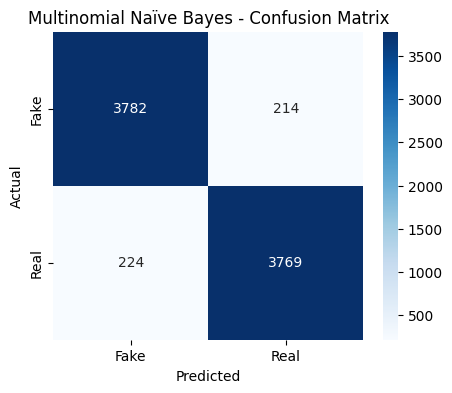

['naive_bayes_model.joblib']

In [85]:
# Train model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predictions
y_train_pred_nb = nb_model.predict(X_train_tfidf)
y_test_pred_nb = nb_model.predict(X_test_tfidf)

# Accuracy
train_acc_nb = accuracy_score(y_train, y_train_pred_nb)
test_acc_nb = accuracy_score(y_test, y_test_pred_nb)

# Print Accuracy
print(f"🔹 Multinomial Naïve Bayes Results:")
print(f"Training Accuracy: {train_acc_nb:.4f}")
print(f"Test Accuracy: {test_acc_nb:.4f}")

# Print Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_nb))

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_test_pred_nb)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Multinomial Naïve Bayes - Confusion Matrix")
plt.show()

# Save Model
joblib.dump(nb_model, 'naive_bayes_model.joblib')

# (2) Logistic Regression

🔹 Logistic Regression Results:
Training Accuracy: 0.9905
Test Accuracy: 0.9880

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3996
           1       0.98      0.99      0.99      3993

    accuracy                           0.99      7989
   macro avg       0.99      0.99      0.99      7989
weighted avg       0.99      0.99      0.99      7989



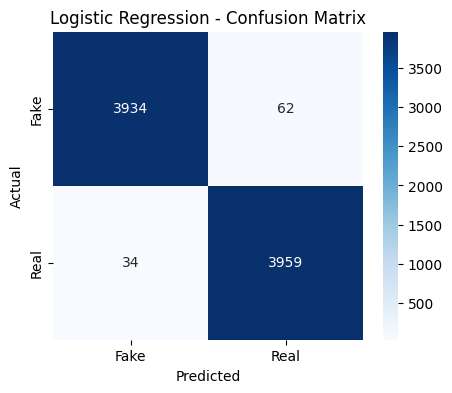

['logistic_regression_model.joblib']

In [86]:
# Train the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_tfidf)
y_test_pred_lr = lr_model.predict(X_test_tfidf)

# Accuracy
train_acc_lr = accuracy_score(y_train, y_train_pred_lr)
test_acc_lr = accuracy_score(y_test, y_test_pred_lr)

# Print Accuracy
print(f"🔹 Logistic Regression Results:")
print(f"Training Accuracy: {train_acc_lr:.4f}")
print(f"Test Accuracy: {test_acc_lr:.4f}")

# Print Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_lr))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

# Save Model
joblib.dump(lr_model, 'logistic_regression_model.joblib')

# (3) Support Vector Machine (SVM)

🔹 Support Vector Machine (SVM) Results:
Training Accuracy: 0.9986
Test Accuracy: 0.9957

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      3996
           1       0.99      1.00      1.00      3993

    accuracy                           1.00      7989
   macro avg       1.00      1.00      1.00      7989
weighted avg       1.00      1.00      1.00      7989



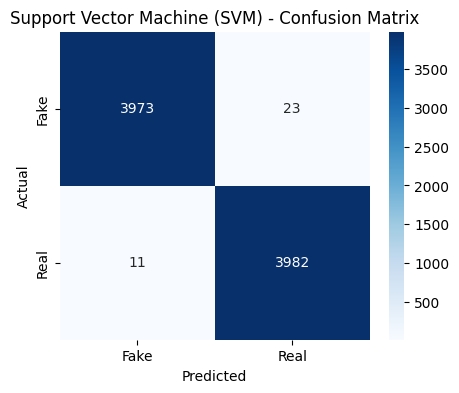

['svm_model.joblib']

In [87]:
# Train the Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Predictions
y_train_pred_svm = svm_model.predict(X_train_tfidf)
y_test_pred_svm = svm_model.predict(X_test_tfidf)

# Accuracy
train_acc_svm = accuracy_score(y_train, y_train_pred_svm)
test_acc_svm = accuracy_score(y_test, y_test_pred_svm)

# Print Accuracy
print(f"🔹 Support Vector Machine (SVM) Results:")
print(f"Training Accuracy: {train_acc_svm:.4f}")
print(f"Test Accuracy: {test_acc_svm:.4f}")

# Print Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_svm))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Support Vector Machine (SVM) - Confusion Matrix")
plt.show()

# Save Model
joblib.dump(svm_model, 'svm_model.joblib')


<ipython-input-88-aa6487fa764a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="coolwarm")


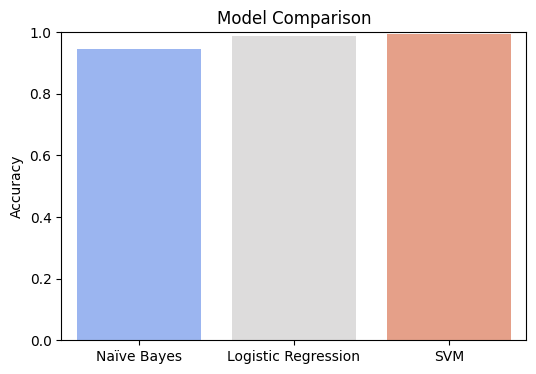

In [88]:
accuracies = {
    "Naïve Bayes": accuracy_score(y_test, y_test_pred_nb),
    "Logistic Regression": accuracy_score(y_test, y_test_pred_lr),
    "SVM": accuracy_score(y_test, y_test_pred_svm)
}

# Plot accuracy comparison
plt.figure(figsize=(6, 4))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="coolwarm")
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.ylim(0, 1)
plt.show()

# Make prediction in validation data

In [89]:
# Load validaion dataset
validation_df = pd.read_csv('/content/drive/MyDrive/Ironhack/validation_data.csv')

# Apply text preprocessing
validation_df['processed_text'] = validation_df['title'] + " " + validation_df['text']
validation_df['processed_text'] = validation_df['processed_text'].apply(lambda x: text_preprocessing(x, ngram_range=(1, 3)))

X_validation_tfidf = vectorizer.transform(validation_df['processed_text'])

y_validation_pred = svm_model.predict(X_validation_tfidf)

validation_df['label'] = y_validation_pred
validation_df.drop(columns=['processed_text'], inplace=True)

validation_df.to_csv('validation_predictions.csv', index=False)



# Build a Word2Vec-based classifier and Conv1D

In [90]:
import gensim.downloader as api
word2vec_model = api.load("word2vec-google-news-300")

In [91]:

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["text"])
sequences = tokenizer.texts_to_sequences(df["text"])

# Padding sequences
max_len = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = np.array(df["label"])

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]





In [92]:
# Build Conv1D Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Conv1D(filters=16, kernel_size=3, activation='relu'),
    Dropout(0.7),
    GlobalMaxPooling1D(),
    Dense(5, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8877 - loss: 0.2886 - val_accuracy: 0.9929 - val_loss: 0.0955 - learning_rate: 0.0010
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9875 - loss: 0.0449 - val_accuracy: 0.9932 - val_loss: 0.0775 - learning_rate: 0.0010
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9900 - loss: 0.0334 - val_accuracy: 0.9956 - val_loss: 0.0503 - learning_rate: 0.0010
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9920 - loss: 0.0262 - val_accuracy: 0.9967 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9917 - loss: 0.0240 - val_accuracy: 0.9971 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9930 - loss: 0.0198 - val_accuracy: 0.9981 - val_loss: 0.0338 - learning_rate: 0.0010
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9933 - loss: 0.0211 -

999/999 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9999 - loss: 0.0126
	rain Accuracy: 0.9998
train Loss: 0.0125
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9988 - loss: 0.0147

Test Accuracy: 0.9987
Test Loss: 0.0148
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3996
           1       1.00      1.00      1.00      3993

    accuracy                           1.00      7989
   macro avg       1.00      1.00      1.00      7989
weighted avg       1.00      1.00      1.00      7989



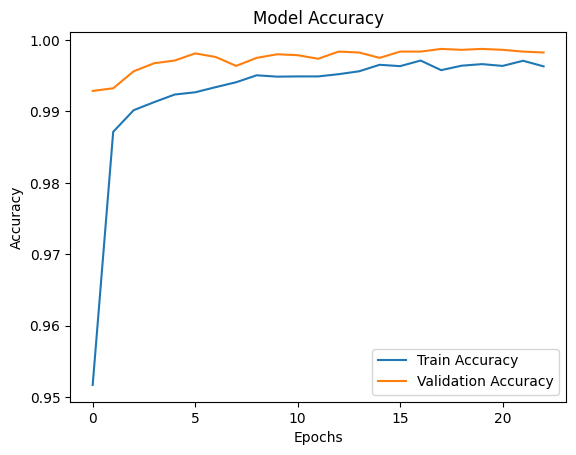

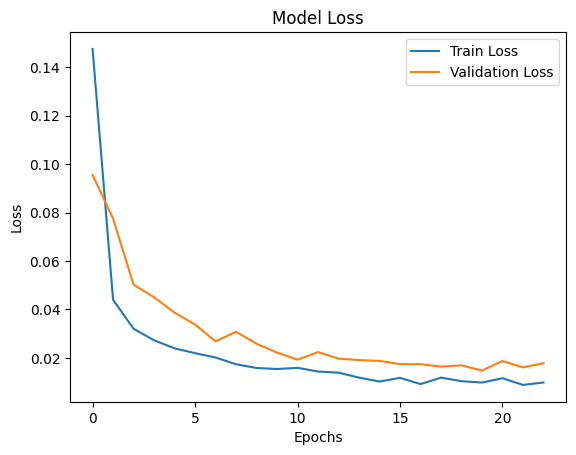

In [93]:
# Evaluate on Test Data
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"\train Accuracy: {train_accuracy:.4f}")
print(f"train Loss: {train_loss:.4f}")
# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get Predictions & Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot Training & Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot Training & Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

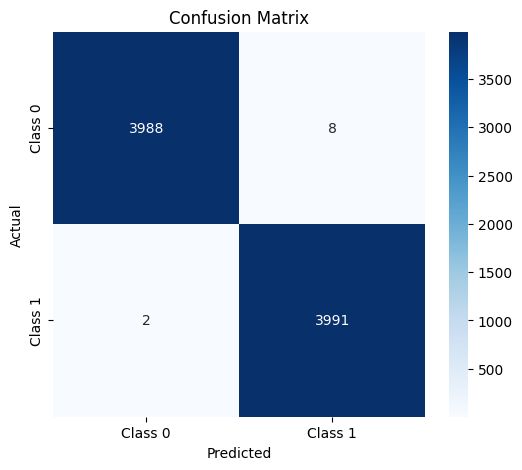

In [94]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [95]:
import pickle
model.save("conv1d_model.h5")
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [96]:
model.save("conv1d_model.keras")


# Build a Word2Vec-based classifier and logistic model

In [97]:
def sentence_to_vec(sentence, word2vec_model):
    # split sentence into words
    words = sentence.split()
    # Extract word vectors
    word_vecs = [word2vec_model[word] for word in words if word in word2vec_model]
    # If no words found, return zero vector
    if len(word_vecs) == 0:
        return np.zeros(word2vec_model.vector_size)
    # Return the mean of the word vectors
    return np.mean(word_vecs, axis=0)

# Apply sentence_to_vec to the processed_text column and create the word2vec column
df['word2vec'] = df['processed_text'].apply(lambda x: sentence_to_vec(x, word2vec_model))

# Check the first few rows of the DataFrame to verify the 'word2vec' column
df.head()


,label,title,text,subject,date,combined_text,processed_text,word2vec
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t...",us budget fight budget fight loom fight loom r...,"[0.0326472, 0.023890981, 0.034660015, 0.127655..."
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...,us military accept military accept transgender...,"[-0.042897355, 0.03612152, 0.04940878, 0.07287..."
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...,senior us republican us republican senator rep...,"[-0.0035376179, 0.028910853, 0.03013404, 0.045..."
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...,fbi russia probe russia probe helped probe hel...,"[-0.016166812, 0.022593997, 0.022650408, 0.003..."
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...,trump want postal want postal service postal s...,"[0.018737307, 0.016770063, -0.029870309, 0.063..."


In [98]:
# Function to preprocess the data using Word2Vec
def preprocess_data_with_word2vec(df, model):
    # Combine title and text to form a single text column
    df['combined_text'] = df['title'].fillna('') + " " + df['text'].fillna('')

    # Apply text preprocessing
    df['processed_text'] = df['combined_text'].apply(lambda x: text_preprocessing(x, ngram_range=(1, 3)))

    # Convert each sentence into its corresponding Word2Vec vector
    df['word2vec'] = df['processed_text'].apply(lambda x: sentence_to_vec(x, model))

    return df

In [99]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['word2vec'].tolist(), df['label'], test_size=0.2, random_state=42)

In [100]:
# Numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)

# build Logestic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Training Accuracy: 0.9516
Test Accuracy: 0.9511
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3996
           1       0.95      0.96      0.95      3993

    accuracy                           0.95      7989
   macro avg       0.95      0.95      0.95      7989
weighted avg       0.95      0.95      0.95      7989



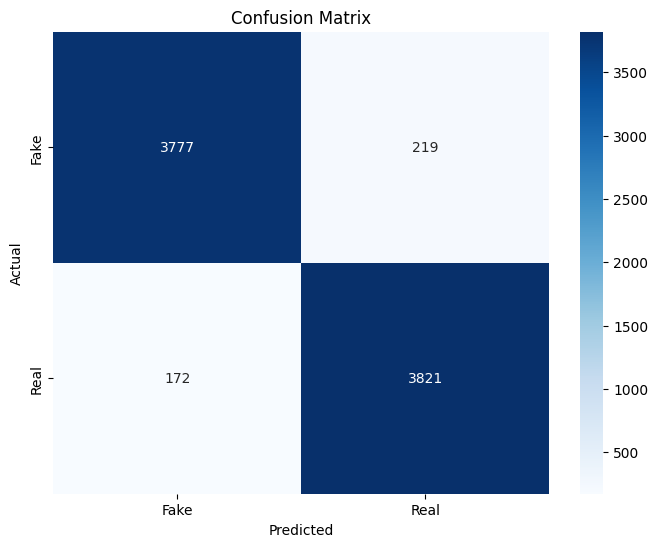

In [101]:
# Evaluatin
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_test_pred)}")

# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [102]:
import joblib

# Save the model
joblib.dump(model, 'logistic_regression_model_word2vec.pkl')

['logistic_regression_model_word2vec.pkl']